# Using GAN to upscale images 

main paper : 

#https://arxiv.org/abs/1609.04802

additional:

1. recidual blocks

НАЙДЕНО https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec

2. pixelshuffle

https://arxiv.org/pdf/1609.05158.pdf

https://keras.io/examples/vision/super_resolution_sub_pixel/

Error: -

# Table of contents
1. [Importing libraries and packages](#IMPORTING-LIBRARIES-AND-PACKAGES)  
   1.1. [General settings](#General-settings)
3. [Model](#Model)  
   3.1. [Generator-submodel](#Generator-submodel)  
   3.2. [Discriminator-submodel](#Discriminator-submodel)  
4. [LOSS FUNCTIONS](#LOSS-FUNCTIONS)  
   4.1. [Discriminator loss](#Discriminator-loss)    
   4.2. [Generator loss](#Generator-loss)  
5. [TRAINING](#TRAINING)  
   5.1 [Loading dataset](#Loading-dataset)  
   5.2 [Training parameters](#Training-parameters)
   
[TEST](#TEST)  

# IMPORTING LIBRARIES AND PACKAGES

In [1]:
# in case of installation, it is recommended to restart the kernel
!pip install datasets
!pip install pydot
!pip install pydotplus
!pip install graphviz

!jupyter --version

Selected Jupyter core packages...
IPython          : 8.16.1
ipykernel        : 6.26.0
ipywidgets       : 8.1.1
jupyter_client   : 8.5.0
jupyter_core     : 5.4.0
jupyter_server   : 2.9.1
jupyterlab       : 4.0.7
nbclient         : 0.8.0
nbconvert        : 7.9.2
nbformat         : 5.9.2
notebook         : 7.0.6
qtconsole        : 5.4.4
traitlets        : 5.12.0


In [2]:
# visualization of data
from PIL import Image
import matplotlib.pyplot as plt 
# technical tool to for saving temporary files
import os
import datetime
import time
# main libraries
import numpy as np
from pandas import DataFrame, ExcelWriter
import tensorflow as tf
import datasets

# tuning

# prevent tensorflow from allocating all GPU memory
physical_devices = tf.config.list_physical_devices('GPU')
# try:tf.config.experimental.set_memory_growth(physical_devices[0], True)
# except:pass

print("GPU:", physical_devices)
print("TensorFlow version:", tf.__version__)

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.13.1


## General settings

In [3]:
# weight made by model.save_weights
load_weights = True
# weight made by tf.train.CheckpointManager
resotre_weights = False
TRAINING = True

weights_folder = "weights/"

# model settings
RESOLUTION_DOUBLING = 2

**secondary functions**

In [4]:
# output image with matplotlib
# input can be image or batch or tensorflow iterator
def visualize(img_data, path=None):
    temp = np.array(img_data)
    data_shape = temp.shape
    if len(temp.shape) < 4:
        temp = np.expand_dims(temp, 0)
    fig, ax = plt.subplots(ncols=len(temp), figsize=(10, 10), squeeze=False)
    for indx, img in enumerate(temp):
        ax[0][indx].imshow(img)
    return data_shape

# Model

## Generator-submodel

* GAN uses two models, a generator model that generates output and a discriminator model that classifies wether the output is generated by the generator model(fake) or taken from the dataset(real)

* The generator model is a U-Net. It is a neural network used for image to image tasks. It has three major components : downsampling blocks, upsampling blocks and skip connections.

* Downsampling blocks convert image input to tensors of lower dimesions until it becomes a 1D tensor. Upsampling blocks convert output of downsampling blocks back to image output. Skip connections provide connections between downsampling and upsampling blocks at each level.

* Generator and discriminator compete against each other.

pixel shuffler 

chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://arxiv.org/pdf/1609.05158.pdf


In [5]:
# repeatable generator part
def generator_block(filters, size, name=None):
    conv_args = {
        "kernel_initializer": tf.random_normal_initializer(0., 0.02),
        #"kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    #relu02= lambda x: tf.keras.activations.relu(x, alpha=0.2)
    
    result = tf.keras.Sequential(name=name)
    
    result.add(tf.keras.layers.Conv2D(filters,
                                      size,
                                      **conv_args))
    result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.Activation('relu',
                                          trainable=False))
    result.add(tf.keras.layers.Conv2D(filters,
                                      size,
                                      **conv_args))
    result.add(tf.keras.layers.BatchNormalization())
    
    return result


# upsumpling submodel/layer


def pixelshuffler(size, filters, up_factor=2):
    conv_args = {
        "kernel_initializer": tf.random_normal_initializer(0., 0.02),
        #"kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inp = tf.keras.layers.Input(shape=[None, None, filters],
                                ragged=True,
                                dtype=tf.float32,
                                name='shuf_input')
    inp = inp.to_tensor()
    x = tf.keras.layers.Conv2D(
        filters*up_factor*up_factor,
        size,
        **conv_args)(inp)
    x = tf.nn.depth_to_space(x, up_factor)
    outputs = tf.keras.layers.Activation('relu',
                                         trainable=False)(x)
    return tf.keras.Model(inp, outputs)

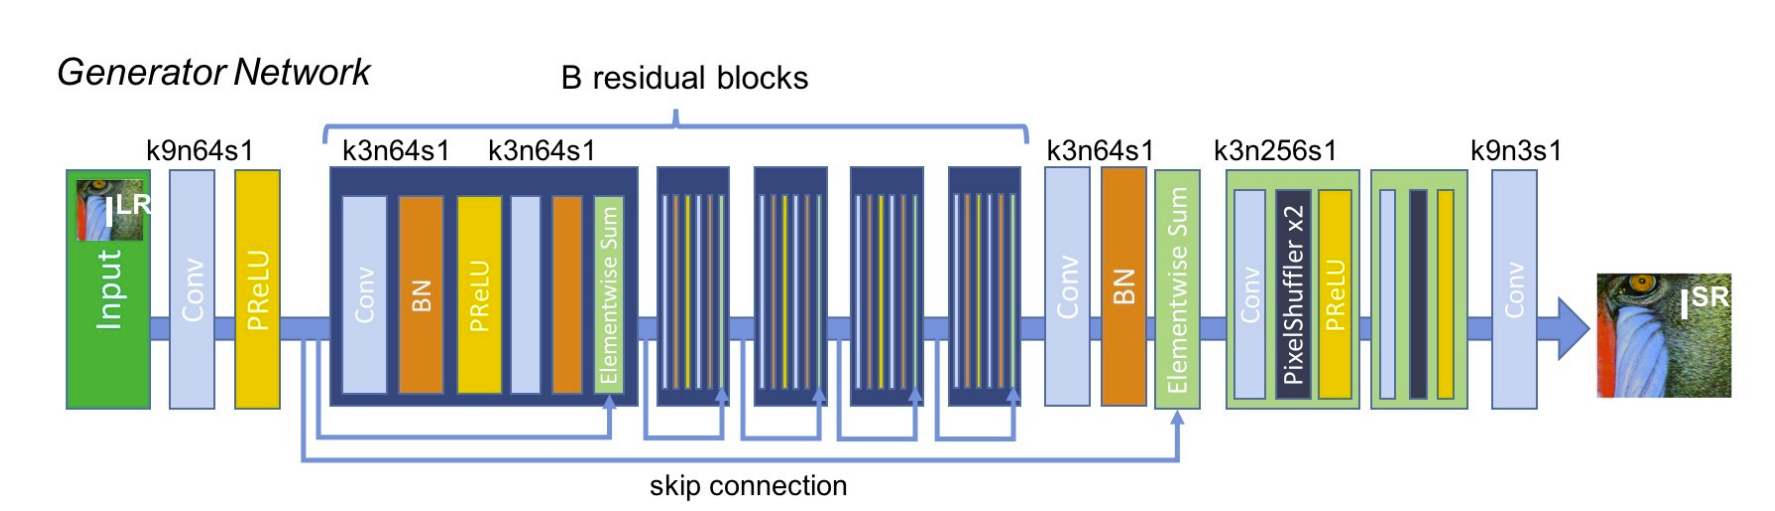

In [6]:
# model to upsampling low resolution images
# getting as input any image and giving as output image with resolution*8
def Generator():
    conv_args = {
        "kernel_initializer": tf.random_normal_initializer(0., 0.02),
        #"kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    
    b_residual_block = [generator_block(64, 3, name="brb"+str(i)) for i in range(16)]# 16
    
    inp = tf.keras.Input(shape=[None, None, 3],
                         ragged=True)
    inp = inp.to_tensor(name='gen_input_image')
    
    x = tf.keras.layers.Conv2D(filters=64,
                               kernel_size=9,
                               activation='relu',
                               **conv_args)(inp)
    temp = x
    for layer in b_residual_block:
        x = tf.math.add(x, layer(temp))
        
    x = tf.keras.layers.Conv2D(filters=64, 
                               kernel_size=3,
                               **conv_args)(x) 
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.math.add(x, temp)
    
    for i in range(RESOLUTION_DOUBLING):
        x = pixelshuffler(
                filters=64,
                size=3)(x)
        
    x = tf.keras.layers.Conv2D(
        filters=3,
        kernel_size=9,
        activation=tf.keras.activations.sigmoid,
        **conv_args)(x)
    
    return tf.keras.Model(inputs=inp, outputs=x, name="generator")

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d_32 (Conv2D)          (None, None, None, 64)       15616     ['input_4[0][0]']             
                                                                                                  
 brb0 (Sequential)           (None, None, None, 64)       74368     ['conv2d_32[1][0]']           
                                                                                                  
 tf.math.add (TFOpLambda)    (None, None, None, 64)       0         ['conv2d_32[1][0]',           
                                                                     'brb0[1][0]']        

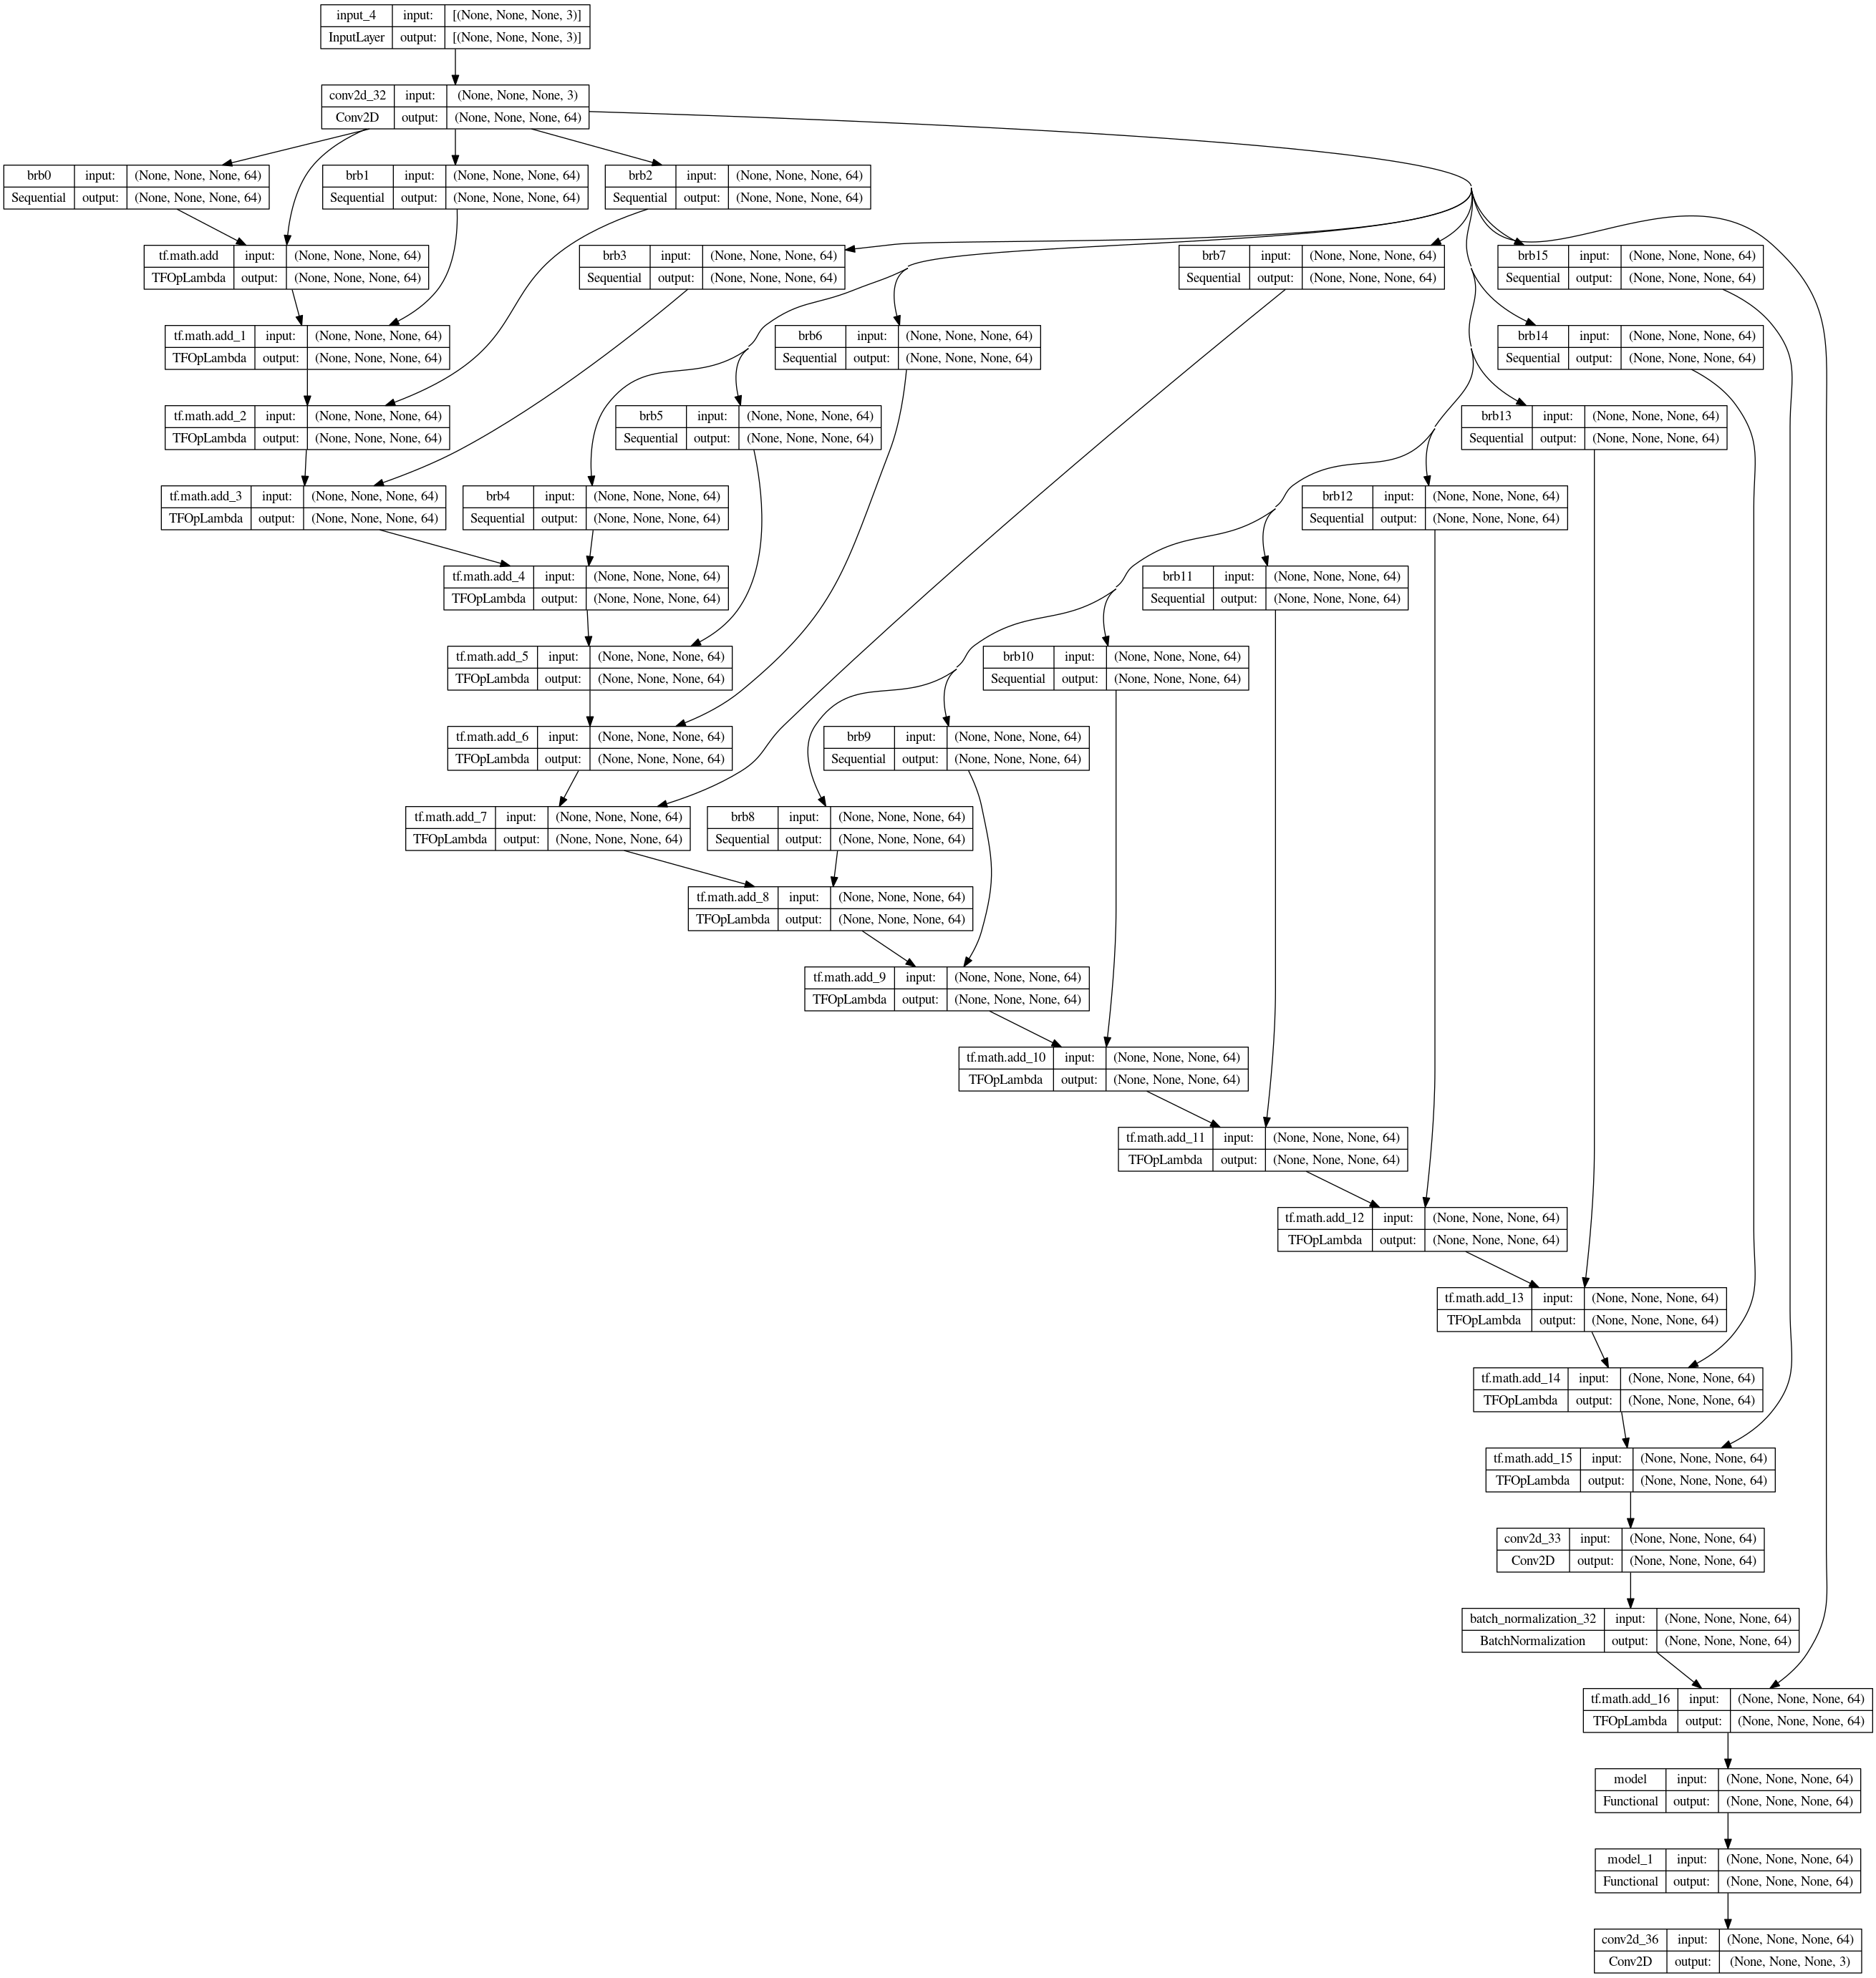

In [7]:
# initialize generator
generator = Generator()

# summary of trainable weight
generator.summary()
# plot the model grathp
tf.keras.utils.plot_model(generator, show_shapes=True)

## Discriminator-submodel

* Discriminator model is a PatchGAN
* In a PatchGAN, the output is a 3D vector referring to similarity between patches of input and target images
* Model consists of downsampling blocks : Conv->BatchNorm->LeakyReLU
* It receives two inputs : Input image and generated image which is classified as fake and input image and target image which is classified as real

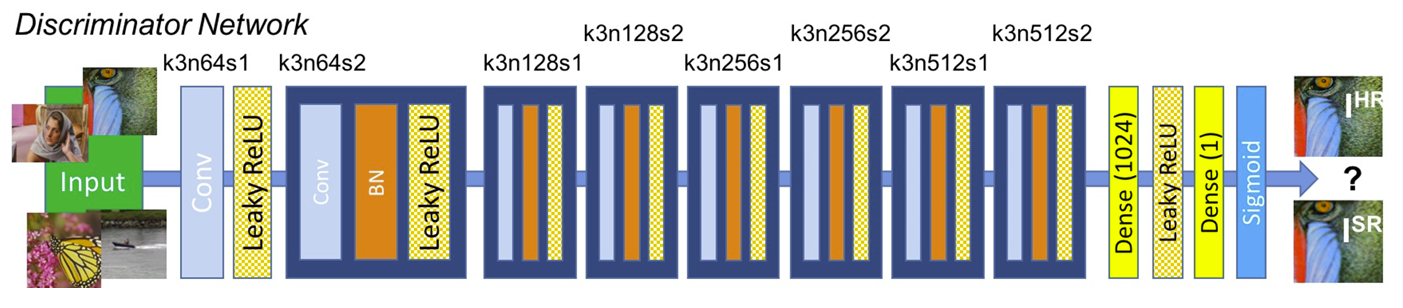


In [8]:
# repeatable discriminator part
def discriminator_block(filters, size, strides=1):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides,
                                      padding='same',
                                      kernel_initializer=initializer))
    result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU(alpha=0.2,
                                         trainable=False))
    
    return result

# test dropout

# model for recognizing true photos among generated images
# getting an input array of images and giving an output array of values from 0 to 1 for each pixel


def Discriminator():
    #inputs = tf.keras.layers.Input(shape = [512,512,3])
    initializer = tf.random_normal_initializer(0. , 0.02)

    inputs = tf.keras.Input(shape=[None, None, 3],
                            ragged=True)
    inputs = inputs.to_tensor(name='dis_input_image')
    
    # discriminator_block
    # feature map x2 each layer, 
    # kernel 3x3, 
    # strides on every second layer that downsampling image
    down_stack = [
        tf.keras.layers.Conv2D(64, 3,
                               padding='same',
                               kernel_initializer=initializer),
        tf.keras.layers.LeakyReLU(alpha=0.2,
                                  trainable=False),
        discriminator_block(64, 3, 2),
        discriminator_block(128, 3, 1),
        discriminator_block(128, 3, 2),
        discriminator_block(256, 3, 1),
        discriminator_block(256, 3, 2),
        discriminator_block(512, 3, 1),
        discriminator_block(512, 3, 2),
        tf.keras.layers.Dense(1024),
        tf.keras.layers.LeakyReLU(alpha=0.2,
                                  trainable=False),
        tf.keras.layers.Dense(1),
        tf.math.sigmoid,
    ]
    x = inputs
    for down in down_stack:
        x = down(x)
    x = tf.reduce_mean(x, [1, 2, 3])
    return tf.keras.Model(inputs=inputs, outputs=x, name="discriminator")

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv2d_37 (Conv2D)          (None, None, None, 64)    1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, None, None, 64)    0         
                                                                 
 sequential (Sequential)     (None, None, None, 64)    37184     
                                                                 
 sequential_1 (Sequential)   (None, None, None, 128)   74368     
                                                                 
 sequential_2 (Sequential)   (None, None, None, 128)   148096    
                                                                 
 sequential_3 (Sequential)   (None, None, None, 256) 

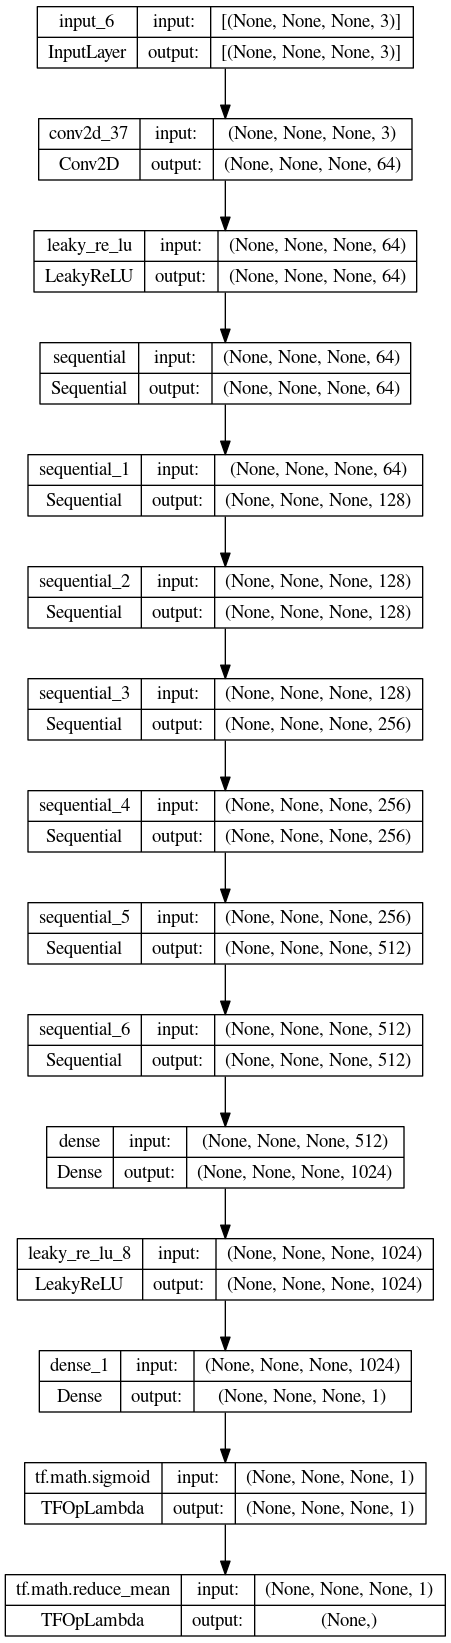

In [9]:
# initializing discriminator
discriminator = Discriminator()

# summary of trainable variables
discriminator.summary()
# plot the modle grathp
tf.keras.utils.plot_model(discriminator, show_shapes=True)

# LOSS FUNCTIONS

## Discriminator loss

* It takes two inputs : discriminator output for real images and generated images and it has two components : real loss and generated loss
* real loss is sigmoid cross entropy loss of real image output and array of ones
* generated loss is sigmoid cross entropy loss of generated image output and array of zeros
* total loss is sum of real loss and generated loss

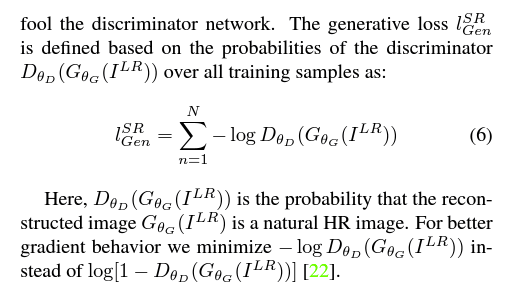

In [10]:
def discriminator_loss(tar_img, gen_img):
    #input: B[H[W[C[0:1]]]]
    #B-Butch; H-Height; W-Width; C-Channels
    #and range of variance inside that array
    real_component = tf.math.log(tar_img)     #B[C[-∞:0]]
    gen_component = tf.math.log(tf.ones_like(gen_img) - gen_img)
    log_loss = -tf.math.reduce_mean(real_component+gen_component)
    del real_component, gen_component
    return log_loss

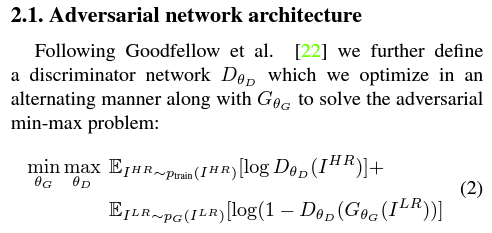

## Generator loss

* Generator loss consists of two components
* L1 loss which is mean absolute error between the generated image and target image to make generated images structurally similar to target images
* GAN loss which is binary crossentropy loss of discriminator's output on generated images and array of ones.
* Total loss = GAN loss + (LAMBDA * L1 loss)

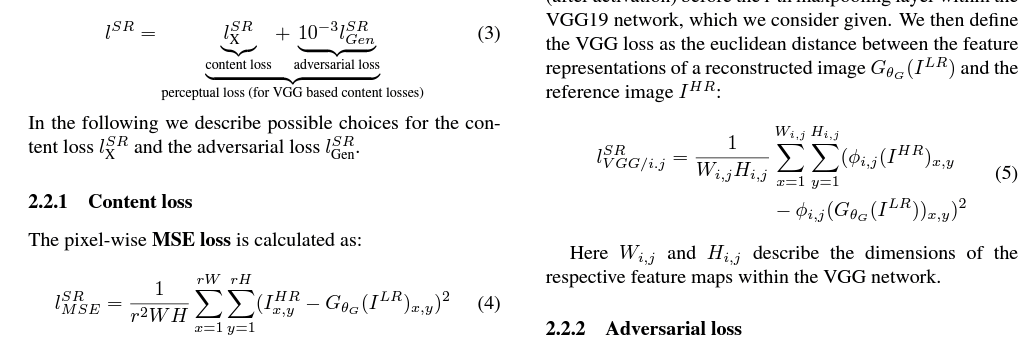

In [11]:
# for test
# adversarial_loss = tf.keras.losses.CategoricalCrossentropy()
# VGGmodel = tf.keras.applications.vgg16.VGG16(include_top=False,input_shape=(512,512,3))

# declaring loss functions

def generator_loss(gen_output, target, dis_probability=1):
    mse_loss = tf.keras.losses.MeanSquaredError()(target, gen_output)
    adv_loss = -tf.math.reduce_mean(tf.math.log(dis_probability))
    total_gen_loss = mse_loss + adv_loss
    del mse_loss, adv_loss
    return total_gen_loss

**OPTIMIZERS AND CHECKPOINT SAVER**

In [12]:
# initialization and tuning of problem optimizer
DELTA = 1e-4
generator_optimizer = tf.keras.optimizers.Adam(DELTA, beta_1=0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(DELTA, beta_1=0.9)
# model saves manager
checkpoint_dir = "./training_checkpoints"
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=10)

    https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch
    https://www.tensorflow.org/guide/data
    dataset3 = tf.data.Dataset.zip((dataset1, dataset2))


# TRAINING

## Loading dataset

Found 81655 files belonging to 1 classes.
(4, 256, 256, 3)


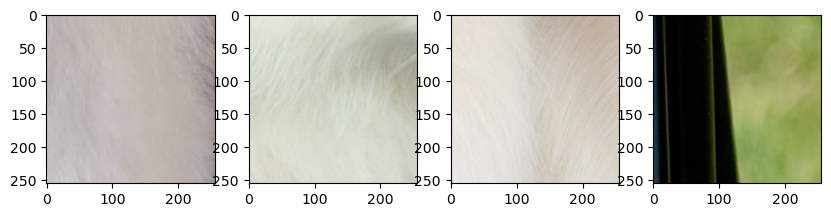

In [13]:
# cuts the image into equal pieces

DATATYPE = tf.float32
BATCHSIZE = 64

#DIRNAME = "datasets/DIV2K_256/"
DIRNAME = "datasets/Dog_breed_Japanese_Spitz_256/"


def fragmentize(input_image,
                frame_size=512):
    result = np.array(input_image)
    crop_border = [result.shape[0]%frame_size, result.shape[1]%frame_size]
    crop_border = np.array([result.shape[0], result.shape[1]]) - crop_border
    result = result[:crop_border[0], :crop_border[1], :]
    result = result.reshape((-1, int(crop_border[0]/frame_size), crop_border[1], frame_size, 3),order='A')
    result = result.reshape((-1, frame_size, frame_size, 3),order='F')
    return result


def create_dataset(save_path_name="/dataset/",
                   img_size=512,
                   force_creation=False,
                   mode=1):
    os.makedirs(save_path_name, exist_ok=True)
    content = os.listdir(save_path_name)
    if len(content) != 0 and not force_creation:
        return save_path_name
    
    if mode == 1:
        from datasets import load_dataset
        dataset = load_dataset("Morevorot/Dog_breed_Japanese_Spitz", split="train")
        
        for counter, element in enumerate(dataset):
            print("file number:", counter, end='\r')
            # fragmentize
            width, height = element["image"].size
            if width < img_size or height < img_size: continue
            batch = fragmentize(element["image"], img_size)
            for index, fragment in enumerate(batch):
                temp = Image.fromarray(fragment)
                width, height = temp.size
                temp.save(save_path_name + f"img-{counter}_fragment-{index}.jpg", "JPEG")
        print()
        return save_path_name
    if mode == 2:
        from datasets import load_dataset 
        dataset = load_dataset('eugenesiow/Div2k', 'bicubic_x2', split='all')
        
        for counter, element in enumerate(dataset):
            print("file number:", counter, end='\r')
            # fragmentize
            img_path = element["hr"]
            pilimg = Image.open(img_path)
            width, height = pilimg.size
            if width < img_size or height < img_size: continue
            batch = fragmentize(pilimg, img_size)
            for index, fragment in enumerate(batch):
                temp = Image.fromarray(fragment)
                width, height = temp.size
                temp.save(save_path_name + f"img-{counter}_fragment-{index}.jpg", "JPEG")
        print()
        return save_path_name


def load_dataset(img_size=512,
                 dir_name="/"):
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    # load from local drive
    dataset = tf.keras.utils.image_dataset_from_directory(dir_name,
                                                          image_size=(img_size,img_size),
                                                          shuffle=True,
                                                          labels=None,
                                                          batch_size=BATCHSIZE,
                                                          crop_to_aspect_ratio=True)
    dataset = dataset.map(lambda x: normalization_layer(x))
    dataset = dataset.map(lambda x: tf.cast(x, DATATYPE))
    return dataset


if TRAINING is True:
    resolution = 256
    dataset_path = create_dataset(img_size=resolution,
                                  save_path_name=DIRNAME,
                                  force_creation=False,
                                  mode=1)
    train_ds = load_dataset(dir_name=dataset_path,
                            img_size=resolution)
    test_sample = next(iter(train_ds))[0:4]
    print(visualize(test_sample))

In [14]:
if resotre_weights: 
    try:
        checkpoint.restore(ckpt_manager.latest_checkpoint)
    except Exception as ex:
        print(ex)

generatr_weights_path = "weights/generator_version_20240115_weights_20240118"
discriminator_weights_path = "weights/discriminator_version_20240115_weights_20240118"

if load_weights is True:
    generator.load_weights(generatr_weights_path)
    discriminator.load_weights(discriminator_weights_path)

## Training parameters

In [15]:
# number of iterations
EPOCHS = 1
# limit the dataset images to train model with
LIMIT = None
# number of generator update compare to discriminator
COUNTER_PERIOD = 1

# model of training the models
#@tf.function


def fit(hr_input, epochs, data_limit=None, rhythm=1):
    metadata_file = "logs/model_training_metadata.xlsx"
    sheet_n = "Sheet"
    os.makedirs("logs/", exist_ok=True)
    if not os.path.isfile(metadata_file):
        os.makedirs("logs/", exist_ok=True)
        learning_values = DataFrame(columns=["time",
                                             "gen error",
                                             "dis error",
                                             "quantity",
                                             "rhythm",
                                             "batch",
                                             "mse"])
        learning_values.to_excel(metadata_file,
                                 sheet_name=sheet_n,
                                 index=False)
    rng = np.random.default_rng()
    sum_rhythm = 0
    for epoch in range(epochs):  
        rhythm_calculated = rhythm
        # switch to limited part of dataset
        dataset_iterator = hr_input
        if data_limit: 
            dataset_iterator = hr_input.take(data_limit)

        # containers
        start_time = time.time()
        counter, d_counter, status_line = 1, 1, " "*100
        gen_loss_sum = 0
        dis_loss_sum = 0
        mse_loss_sum = 0
        learning_values = DataFrame(columns=["time",
                                             "gen error",
                                             "dis error",
                                             "quantity", 
                                             "rhythm", 
                                             "batch", 
                                             "mse"])
        learning_values.loc[len(learning_values)] = [-1, -1., -1., 0, rhythm, BATCHSIZE, -1.]

        # cycle through dataset
        for batch in dataset_iterator:
            unit_shape = batch.shape
            input_img_size = int(unit_shape[-2]/(2**RESOLUTION_DOUBLING))
            swithc = rng.random()

            # half step for generatro submodel
            with tf.GradientTape() as g_tape:
                # compress to computable size, add noises with random frequency
                temp = tf.image.resize(batch, (input_img_size, input_img_size))
                if swithc < 0.1: 
                    temp = tf.keras.layers.GaussianNoise(swithc)(temp)
                    temp = tf.keras.layers.RandomContrast(factor=swithc)(temp)
                    temp = tf.keras.layers.RandomBrightness(factor=swithc)(temp)

                # model's play through
                gen_output = generator(temp, training = True)
                dis_prediction = discriminator(gen_output, training = False)

                # loss accumulation
                gen_loss = generator_loss(gen_output, batch, dis_prediction)  
                gen_loss_sum += gen_loss

                # meta data
                mse_loss_sum += tf.keras.losses.MeanSquaredError()(gen_output, batch)

                del gen_output, dis_prediction, temp
            # add loss gradient
            gen_grads = g_tape.gradient(gen_loss, generator.trainable_variables)
            generator_optimizer.apply_gradients(zip(gen_grads, generator.trainable_variables))

            del gen_grads
            # half step for discriminator submodel, skip every COUNTER_PERIOD steps
            if counter % rhythm_calculated == 0:
                # half step for generatro submodel
                with tf.GradientTape() as d_tape:
                    # compress to computable size
                    temp = tf.image.resize(batch, (input_img_size, input_img_size))
                    if swithc < 0.1: 
                        temp = tf.keras.layers.GaussianNoise(swithc)(temp)
                        temp = tf.keras.layers.RandomContrast(factor=swithc)(temp)
                        temp = tf.keras.layers.RandomBrightness(factor=swithc)(temp)

                    # model's play through
                    gen_output = generator(temp, training=False)
                    dis_real_output = discriminator(batch, training=True)
                    dis_gen_output = discriminator(gen_output, training=True)

                    # loss accumulation
                    dis_loss = discriminator_loss(dis_real_output, dis_gen_output)
                    dis_loss_sum += dis_loss

                    del gen_output, dis_real_output, dis_gen_output
                # add loss gradient
                dis_grads = d_tape.gradient(dis_loss, discriminator.trainable_variables)
                discriminator_optimizer.apply_gradients(zip(dis_grads, discriminator.trainable_variables))

                # update containers
                ##rhythm_calculated = int(1 + gen_loss/dis_loss)
                rhythm_calculated = int(1 + (gen_loss_sum/counter)/(dis_loss_sum/d_counter))
                sum_rhythm += rhythm_calculated
                d_counter += 1

                del dis_grads
            # update containers, viwe monitor process
            counter += 1
            status_line = f"EP:{epoch+1} C:{counter} t:{int(time.time()-start_time)} DL:{dis_loss_sum/d_counter:.4f} GL:{gen_loss_sum/counter:.4f} MSE:{mse_loss_sum/counter:.4f} RH:{sum_rhythm/d_counter:.1f}"
            print(status_line, end="\r")
        # save, next statistic line, clear some memory
        ckpt_manager.save()
        status_line = f"EP:{epoch+1:<2} C:{counter:} t:{int(time.time()-start_time):} DL:{dis_loss_sum/d_counter:.4f} GL:{gen_loss_sum/counter:.4f} MSE:{mse_loss_sum/counter:.4f} RH:{sum_rhythm/d_counter:.1f}"
        try:
            with ExcelWriter(metadata_file,
                             mode='a',
                             if_sheet_exists='overlay') as writer:
                learning_values.loc[len(learning_values)-1] = [time.time()-start_time,
                                                               gen_loss_sum/counter,
                                                               dis_loss_sum/d_counter,
                                                               counter,
                                                               sum_rhythm/d_counter,
                                                               BATCHSIZE,
                                                               mse_loss_sum/counter]
                learning_values.to_excel(writer,
                                         sheet_name=sheet_n,
                                         startrow=writer.sheets[sheet_n].max_row,
                                         index=False,
                                         header=False)
        except Exception as ex:
            print(ex) 
            pass
        print(status_line)

# start training
# mode 1 is a discriminator trainer
# mode 2 is a custom model
# mode 3 is a tensorflow basic approach


if TRAINING is True:
    mode = 2
    if mode == 2:
        fit(train_ds, EPOCHS, data_limit=LIMIT, rhythm=COUNTER_PERIOD)
    if mode == 3:
        generator.compile(optimizer=generator_optimizer,
                          loss='mse',
                          metrics=['mae', 'msle'])

        generator.fit(tf.data.Dataset.zip((train_ds.map(lambda x: tf.image.resize(x, (128, 128))), 
                                           train_ds)),
                      epochs=EPOCHS)
        ckpt_manager.save()

Append mode is not supported with xlsxwriter!0229 RH:89637.5
EP:1  C:1277 t:1003 DL:0.0000 GL:0.0521 MSE:0.0229 RH:89637.5


# TEST

D Input: 0.05813175 0.05813175 0.05813175
D Gen:    0.3835748 0.3835748 0.3835748
DL:       tf.Tensor(3.3288615, shape=(), dtype=float32)


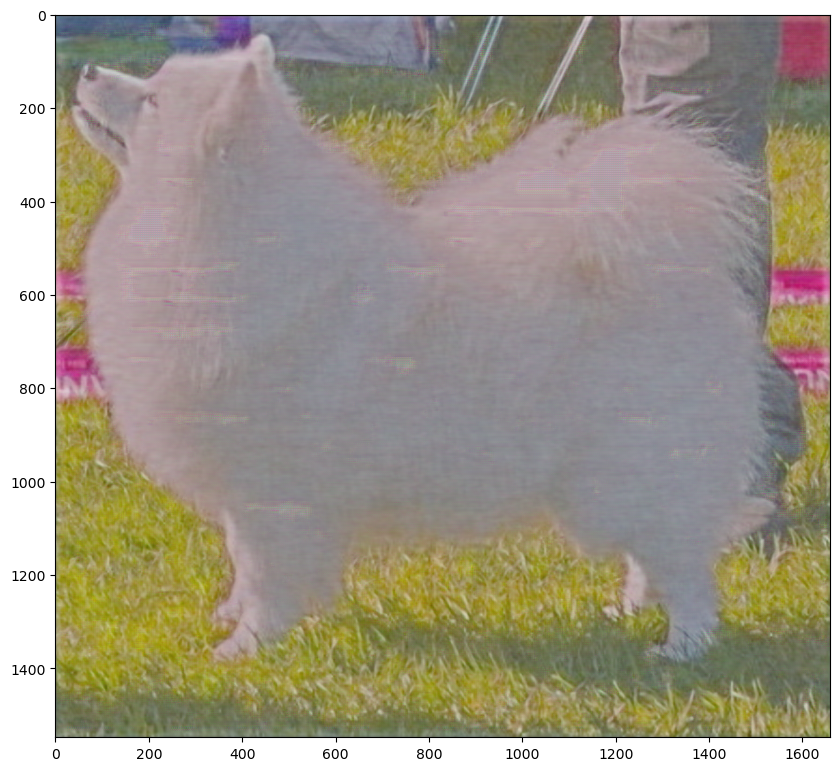

In [16]:
# selected test images processing generator and will be saved at given folder
TEST_IMAGE_PATH = "test files/input.jpg"
OUTPUT_SAVE_DIRECTORY = "results/"

# choosing CPU devica because GPU resources are not freed after training
if True:
    with tf.device('/CPU:0'):
        os.makedirs(OUTPUT_SAVE_DIRECTORY, exist_ok=True)
        # get data
        filename_input = TEST_IMAGE_PATH
        test_image = Image.open(filename_input)
        test_image = np.array([test_image])/255.

        # process with model
        dis_prob_input = discriminator(test_image)
        test_image = generator(test_image)
        dis_prob_gen = discriminator(test_image)

        # technical output
        print("D Input:", np.min(dis_prob_input), np.max(dis_prob_input), np.mean(dis_prob_input))
        print("D Gen:   ", np.min(dis_prob_gen), np.max(dis_prob_gen), np.mean(dis_prob_gen))
        print("DL:      ", discriminator_loss(dis_prob_input, dis_prob_gen))
        visualize(test_image)

        # save on drive
        name = OUTPUT_SAVE_DIRECTORY+"generated_output_"+datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")+".jpg"
        test_image = test_image.numpy()[0]*255
        test_image = Image.fromarray(test_image.astype(np.uint8))
        test_image.save(name)
        del test_image, dis_prob_input, dis_prob_gen

In [17]:
if False:
    # names for model.save_weights directive
    postfix = "_version_20240115_weights_20240118"
    os.makedirs(weights_folder, exist_ok=True)

    discriminator.save_weights(weights_folder + 'discriminator' + postfix)
    generator.save_weights(weights_folder + 'generator' + postfix)

    print("files:\n",
          weights_folder + 'discriminator' + postfix,
          "\n",
          weights_folder + 'generator' + postfix)


files:
 weights/discriminator_version_20240115_weights_20240118 
 weights/generator_version_20240115_weights_20240118
